In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import scipy as sp
from tqdm import tqdm

# I) Investigating Diabetes Trends in the Synthea Data

In this module, we will:
1. Load and explore synthetic EHR data generated using Synthea.
2. Identify patients diagnosed with Type 2 Diabetes using SNOMED CT codes.
3. Analyze Hemoglobin A1C (HbA1c) levels in diabetic and non-diabetic patients.
4. Visualize data distributions and perform statistical testing.
5. Discuss findings and explore possible extensions.

## I.a) Loading of Relevant Data
Data for 1,000 synthetic patients, divided into four states, was generated using the [Synthea tool](https://synthea.mitre.org/)
This data is split into four separate directories
```
output_hi/ # patients in Hawaii
output_ma/ # patients in Massacusetts
output_tx/ # patients in Texas
output_wa/ # patients in Washington
```

In part 1 of this two workshop series, we worked exclusively with the patient demographics data stored in patients.parquet
For the subsequent investigation, we will be relying on data stored across three new files:
- `conditions.parquet`: Stores SNOMED CT coded patient conditions and diagnoses
- `observations.parquet`: Includes vital signs and LOINC coded lab results for all patients
- `medications.parquet`: Tracks RxNorm coded medication prescribing and dispensing/fill data for all patients \
Below is a convenience function that can be used to load the concatenated conditions, observations, and medications for all states
into a single data frame

In [2]:
def load_data_for_file(filename):
    print(f"Loading data for {filename}")
    url_prefix = "https://github.com/btwooton/arch_workshop_data_wrangling2_ws10/raw/refs/heads/main/data/"
    df = pd.concat([ # use pd.concat to append/concatenate the data for all states together into a single frame
        pd.read_parquet(f"{url_prefix}{output_dir}/parquet/{filename}") # use read_csv to load the data from each output directory
        for output_dir in tqdm(['output_hi_small', 'output_ma_small', 'output_tx_small', 'output_wa_small']) # loop over each output directory
    ])
    return df

In [3]:
# load in the patients, conditions, observations, and medications data
patients = load_data_for_file('patients.parquet')
conditions = load_data_for_file('conditions.parquet')
observations = load_data_for_file('observations.parquet')
medications = load_data_for_file('medications.parquet')

Loading data for patients.parquet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


Loading data for conditions.parquet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it]


Loading data for observations.parquet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.60s/it]


Loading data for medications.parquet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.35s/it]


In [4]:
patients

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,LAST,...,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,2019-03-22,None,999-92-3671,None,None,None,Everette494,None,Hartmann983,...,San Jose,California,Santa Clara County,6085.0,95135,37.263382,-121.950809,14812.42,0.00,129251
1,10c85239-f74b-cd18-8f01-40869916a5d6,2019-02-06,None,999-44-6829,None,None,None,Shira43,Sharonda198,Strosin214,...,Fremont,California,Alameda County,6001.0,94536,37.604365,-121.979272,26380.74,16891.24,63477
2,6b9f402c-1405-d749-e01f-2138a7cbdc07,1985-09-25,1990-07-17,999-95-9496,None,None,None,Tiffiny991,Kylie930,Hoppe518,...,Duarte,California,Los Angeles County,6037.0,91008,34.138904,-117.921619,184465.32,121063.22,62882
3,6ae1b39f-797e-e0e6-d25b-7b49a172e331,2011-02-16,None,999-70-4318,None,None,None,Shaun461,None,Nienow652,...,Tustin,California,Orange County,6059.0,92701,33.708073,-117.802957,62542.10,282379.72,690066
4,493db0f8-f2ef-e6a3-6fc6-3a648bd8867a,2002-02-21,None,999-27-4149,S99999679,X52207866X,Mr.,Hipolito984,Elias404,Schuster709,...,Covina,California,Los Angeles County,6037.0,91724,34.049886,-117.897099,80408.98,18505.24,65695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,77ff5093-61b4-c7aa-e770-b19c6b9d671b,1970-12-12,None,999-27-1689,S99970616,X23307256X,Mrs.,Carrol931,Lyndia317,Hodkiewicz467,...,Prairie Ridge,Washington,Pierce County,NaN,0,47.185984,-122.132548,277056.33,83623.00,162911
270,ce2b13d5-7ee6-2270-0ff8-9c326f9378f0,1959-07-13,None,999-67-8758,S99995820,X24776373X,Mr.,Arlen68,Darrin898,Beier427,...,Port Orchard,Washington,Kitsap County,53035.0,98366,47.525178,-122.737322,169113.04,53548.98,57433
271,6bb0fe32-56fe-c197-db6f-286e80e33e21,1942-11-06,None,999-84-7624,S99934671,X2383812X,Ms.,Berta524,None,Moreno82,...,Yakima,Washington,Yakima County,53077.0,98901,46.723365,-120.371073,1035410.62,1024771.78,65640
272,a9386e31-e309-17d9-3671-566459a7f72e,1973-06-01,None,999-21-9302,S99987720,X23715571X,Mr.,Damion480,Brenton674,Cremin516,...,Des Moines,Washington,King County,53033.0,98198,47.426292,-122.330704,25535.33,1143065.93,17034


In [5]:
conditions

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
0,2019-03-22,2019-04-26,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,175d5551-1891-6aaf-91c9-f8da2b3edb67,SNOMED-CT,314529007,Medication review due (situation)
1,2019-06-28,2019-08-30,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,f0f9226d-edae-1af6-d7fe-f0a8aee63865,SNOMED-CT,314529007,Medication review due (situation)
2,2019-11-29,2020-08-28,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,042dc1b3-46c0-7219-f4d4-6ecbaffe65a5,SNOMED-CT,314529007,Medication review due (situation)
3,2019-02-06,2019-03-13,10c85239-f74b-cd18-8f01-40869916a5d6,1e5375c2-ae73-4151-ca0b-5bcbee81e0cc,SNOMED-CT,314529007,Medication review due (situation)
4,2021-02-26,2022-08-26,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,4f86b8ff-dc56-712e-1120-b73574b1606d,SNOMED-CT,314529007,Medication review due (situation)
...,...,...,...,...,...,...,...
11152,2025-01-10,2025-02-14,6bb0fe32-56fe-c197-db6f-286e80e33e21,f87d84f3-87dc-e35f-403d-11d77b72a12f,SNOMED-CT,160904001,Part-time employment (finding)
11153,2025-01-10,None,6bb0fe32-56fe-c197-db6f-286e80e33e21,f87d84f3-87dc-e35f-403d-11d77b72a12f,SNOMED-CT,73595000,Stress (finding)
11154,2025-02-14,None,6bb0fe32-56fe-c197-db6f-286e80e33e21,55d84142-5687-8844-b07c-f0cb5e3dff6e,SNOMED-CT,160903007,Full-time employment (finding)
11155,2025-02-14,None,6bb0fe32-56fe-c197-db6f-286e80e33e21,55d84142-5687-8844-b07c-f0cb5e3dff6e,SNOMED-CT,66383009,Gingivitis (disorder)


In [6]:
observations

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2019-03-22T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,175d5551-1891-6aaf-91c9-f8da2b3edb67,vital-signs,8302-2,Body Height,55.1,cm,numeric
1,2019-03-22T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,175d5551-1891-6aaf-91c9-f8da2b3edb67,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,1.0,{score},numeric
2,2019-03-22T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,175d5551-1891-6aaf-91c9-f8da2b3edb67,vital-signs,29463-7,Body Weight,4.2,kg,numeric
3,2019-03-22T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,175d5551-1891-6aaf-91c9-f8da2b3edb67,vital-signs,77606-2,Weight-for-length Per age and sex,9.4,%,numeric
4,2019-03-22T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,175d5551-1891-6aaf-91c9-f8da2b3edb67,vital-signs,8289-1,Head Occipital-frontal circumference Percentile,84.8,%,numeric
...,...,...,...,...,...,...,...,...,...
260665,2020-11-07T04:54:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,None,None,QOLS,QOLS,0.7,{score},numeric
260666,2021-11-07T04:54:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,None,None,QOLS,QOLS,0.7,{score},numeric
260667,2022-11-07T04:54:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,None,None,QOLS,QOLS,0.6,{score},numeric
260668,2023-11-07T04:54:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,None,None,QOLS,QOLS,0.6,{score},numeric


In [7]:
medications

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2019-08-05T21:18:05Z,2019-08-19T21:18:05Z,10c85239-f74b-cd18-8f01-40869916a5d6,734afbd6-4794-363b-9bc0-6a3981533ed5,1b5881c1-be92-ce18-0839-bf103ea02c0d,308192,Amoxicillin 500 MG Oral Tablet,80.64,64.51,1,80.64,NaN,None
1,2019-08-05T21:18:05Z,2019-08-19T21:18:05Z,10c85239-f74b-cd18-8f01-40869916a5d6,734afbd6-4794-363b-9bc0-6a3981533ed5,1b5881c1-be92-ce18-0839-bf103ea02c0d,198405,Ibuprofen 100 MG Oral Tablet,34.05,27.24,1,34.05,NaN,None
2,2023-01-30T10:06:25Z,2023-02-13T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,26aab0cd-6aba-3e1b-ac5b-05c8867e762c,fdedc79e-f3cc-48eb-69ba-177667fc2192,308192,Amoxicillin 500 MG Oral Tablet,51.90,0.00,1,51.90,NaN,None
3,2023-01-30T10:06:25Z,2023-02-13T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,26aab0cd-6aba-3e1b-ac5b-05c8867e762c,fdedc79e-f3cc-48eb-69ba-177667fc2192,198405,Ibuprofen 100 MG Oral Tablet,70.18,0.00,1,70.18,NaN,None
4,2023-09-22T10:06:25Z,2023-10-06T10:06:25Z,be7a35c4-56b1-212c-7dd4-171e79c7fc7f,26aab0cd-6aba-3e1b-ac5b-05c8867e762c,2eb846c3-da02-941e-8fa3-6cc946f35847,308192,Amoxicillin 500 MG Oral Tablet,121.54,0.00,1,121.54,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18108,2025-02-15T04:24:08Z,2025-02-22T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,a735bf55-83e9-331a-899d-a82a60b9f60c,55d84142-5687-8844-b07c-f0cb5e3dff6e,310798,Hydrochlorothiazide 25 MG Oral Tablet,0.70,0.56,1,0.70,59621000.0,Essential hypertension (disorder)
18109,2025-02-15T04:24:08Z,2025-02-22T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,a735bf55-83e9-331a-899d-a82a60b9f60c,55d84142-5687-8844-b07c-f0cb5e3dff6e,2563431,aspirin 81 MG Oral Capsule,200.25,160.20,7,1401.75,NaN,None
18110,2025-02-22T04:24:08Z,None,6bb0fe32-56fe-c197-db6f-286e80e33e21,a735bf55-83e9-331a-899d-a82a60b9f60c,e1ee6cab-c2be-e4cd-49c4-983d9851281f,106892,insulin isophane human 70 UNT/ML / insulin r...,300.96,240.77,1,300.96,44054006.0,Diabetes mellitus type 2 (disorder)
18111,2025-02-22T04:24:08Z,None,6bb0fe32-56fe-c197-db6f-286e80e33e21,a735bf55-83e9-331a-899d-a82a60b9f60c,e1ee6cab-c2be-e4cd-49c4-983d9851281f,310798,Hydrochlorothiazide 25 MG Oral Tablet,0.96,0.77,1,0.96,59621000.0,Essential hypertension (disorder)


## I.b) Selecting Patients with Type 2 Diabetes Diagnoses
For this investigation, we are interested in patients who have been diagnosed with Type 2 Diabetes \
In order to do this, we filter the conditions table to get all diagnoses of type 2 diabetes \
We can use the SNOMED CT code for type 2 diabetes: `44054006`

In [8]:
diabetes = conditions.query('CODE == 44054006') # we could also use a substring search if we didn't know the code

In [9]:
diabetes

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
699,2022-05-20,None,b0b219dd-59fb-1c49-bf32-74c0f246321b,af322cad-814b-0b78-97bd-328bf9c47e53,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
2607,2007-07-18,None,73f7eae4-318b-620c-3075-bef6a7cc54f3,a516c39c-e2d3-d64f-6d83-88b0953fa92e,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
2662,2009-07-09,None,3f067beb-8ac1-d2ba-6bee-37c9f7d62b41,546591bf-384f-5e10-147b-75880c89da74,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
3040,1988-01-21,None,b48a7ab7-a2d2-b91c-c7d3-e97b30859ea3,a18ab844-8257-9732-1f90-c7b595a18a03,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
4573,2012-01-14,None,bc1cba43-1568-5d2e-a1f8-8a0d2fbec306,c88a6219-3e0c-6682-44d4-5f4246f5848f,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
...,...,...,...,...,...,...,...
9131,2006-03-14,None,be72e253-7fa1-51af-be90-30a3627c2aed,d2a4c19c-c1f4-5066-c247-56e4e669875f,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
9459,2024-08-21,None,89cafa16-4fa9-e12b-6059-4b9c395a36ac,69043279-ea21-120b-4efb-99ab385294f1,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
10211,2019-12-24,None,e747412a-fc7a-c9a7-e41f-db8346e68b65,5fe3c4c3-095e-4c59-5db5-b713228841f9,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
10601,2005-01-14,None,6bb0fe32-56fe-c197-db6f-286e80e33e21,fcae2f1f-31d3-71b8-30b7-be92372d3eac,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)


In [10]:
# count the unique patients with Type 2 diabetes 
# (NOTE: Not always the same as the number shown above for rows, as patients will often have repeat diagnoses depending on the condition/disorder)
diabetes['PATIENT'].nunique()

72

## I.c) Analysis of Hemoglobin A1c (HbA1c) Labs in Type 2 and Non-Type 2 patients
Now we will analyze Hemoglobin A1C levels for patients with and without a diabetes diagnosis \
To do this, we first filter the observations table for all hemoglobin A1C lab results \
We can use LOINC code: `4548-4`

In [11]:
hemoglobin_a1c = observations[observations['CODE'] == '4548-4']

In [15]:
hemoglobin_a1c

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
3187,2016-11-26T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,28949191-7f70-fc8f-4b6a-2c189c7420be,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric
3228,2018-08-25T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,5321b236-5d56-cd4e-9868-5effe754d2b2,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.1,%,numeric
3281,2018-09-08T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,130d07e1-634b-f83e-d15e-167e50b4a892,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,5.9,%,numeric
3324,2018-09-15T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,5f4afa65-126f-33a0-51d9-46311c7f52de,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,5.9,%,numeric
3325,2018-11-03T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,94b4400f-e16c-d2b1-25b9-339469a598ef,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.4,%,numeric
...,...,...,...,...,...,...,...,...,...
260359,2024-12-28T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,be706273-3798-c95b-43b6-adf1c762f202,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric
260454,2025-01-11T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,f87d84f3-87dc-e35f-403d-11d77b72a12f,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric
260529,2025-01-18T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,bc669396-e966-0c81-a033-265f4406dc10,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric
260556,2025-02-15T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,55d84142-5687-8844-b07c-f0cb5e3dff6e,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric


Next we will add another variable/column to the hemoglobin_a1c data to label patients with/without a Type 2 diabetes diagnosis
Here we are performing multiple operations in a single line:
1. The outermost operation is a call to `hemoglobin_a1c.assign()` to assign a new variable/column to the dataframe of HbA1c labs
2. To the new variable `HASDIABETES`, we are assigning a series
3. The series we are assigning is a boolean series created by calling the `.isin()` method, effectively asking if the `PATIENT` ID of the record is in the set of IDs in the type 2 diabetes diagnoses
4. On this boolean series (which by default has values `True` and `False`) we are transforming the values into integers (1 for True, 0 for False) using `.astype('int')` to convert to integers \

*NOTE:* We are cheating/simplifying somewhat. Really what we probably should do is label the HbA1c labs based on whether they occured before/after the diagnosis of Type 2 diabetes (within a certain time delta) to perhaps get a more accurate labeling of the labs. However, this would require creating an auxiliary data structure and lead to more complicated code, so we use this simpler approach for sake of brevity.

In [16]:
hemoglobin_a1c_labeled = hemoglobin_a1c.assign(
    HASDIABETES=hemoglobin_a1c['PATIENT'].isin(diabetes['PATIENT']).astype('int')
)

In [17]:
hemoglobin_a1c_labeled

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE,HASDIABETES
3187,2016-11-26T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,28949191-7f70-fc8f-4b6a-2c189c7420be,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric,0
3228,2018-08-25T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,5321b236-5d56-cd4e-9868-5effe754d2b2,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.1,%,numeric,0
3281,2018-09-08T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,130d07e1-634b-f83e-d15e-167e50b4a892,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,5.9,%,numeric,0
3324,2018-09-15T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,5f4afa65-126f-33a0-51d9-46311c7f52de,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,5.9,%,numeric,0
3325,2018-11-03T20:10:37Z,067d98c9-6bdb-3a85-6369-9e5cce0f3c95,94b4400f-e16c-d2b1-25b9-339469a598ef,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.4,%,numeric,0
...,...,...,...,...,...,...,...,...,...,...
260359,2024-12-28T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,be706273-3798-c95b-43b6-adf1c762f202,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric,1
260454,2025-01-11T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,f87d84f3-87dc-e35f-403d-11d77b72a12f,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric,1
260529,2025-01-18T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,bc669396-e966-0c81-a033-265f4406dc10,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric,1
260556,2025-02-15T04:24:08Z,6bb0fe32-56fe-c197-db6f-286e80e33e21,55d84142-5687-8844-b07c-f0cb5e3dff6e,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,3.8,%,numeric,1


Now we will plot the distributions of A1C in the two groups using the Seaborn package \
and display summary statistics for both

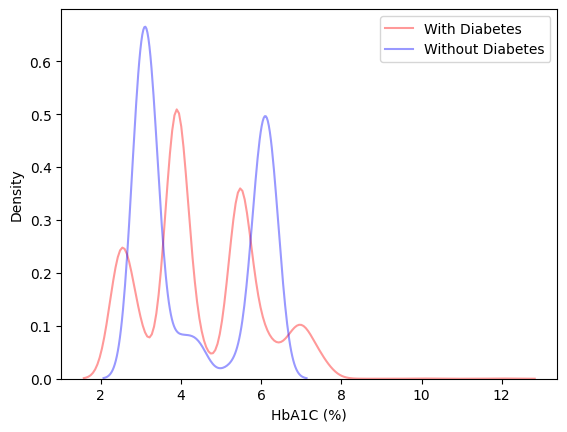

In [18]:
# plot a Kernel Density Estimate of the distrubtion (probability density function) of Hemoglobin A1C lab measurements for Type 2 and Non Type 2 Patients
sns.kdeplot(hemoglobin_a1c_labeled.query('HASDIABETES == 1')['VALUE'].astype('float'), label="With Diabetes", color="red", alpha=0.4, common_norm=False)
sns.kdeplot(hemoglobin_a1c_labeled.query('HASDIABETES == 0')['VALUE'].astype('float'), label="Without Diabetes", color="blue", alpha=0.4, common_norm=False)
# add a legend
plt.legend()
# change label of the xaxis
plt.xlabel('HbA1C (%)')
plt.show()

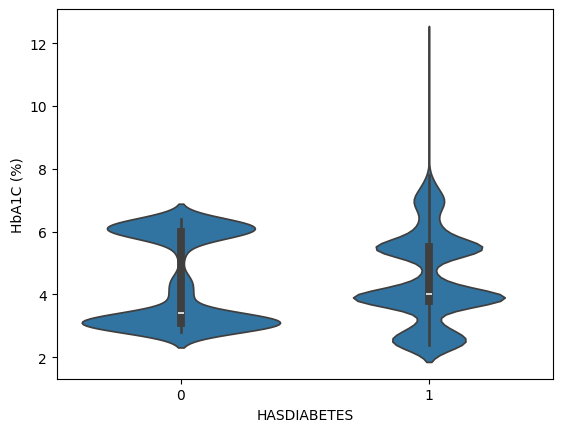

In [19]:
# use seaborn to create a violin plot of the two distributions
sns.violinplot(
    hemoglobin_a1c_labeled.astype({'VALUE': float}),
    x='HASDIABETES',
    y='VALUE'
)
# change the label of the y-axis
plt.ylabel('HbA1C (%)')
plt.show()

The U.S. CDC has the following reference values published for Hemoglobin A1C

Normal: below 5.7% \
Prediabetes: 5.7% to 6.4% \
Diabetes: 6.5% or above 

In looking at the distribution plots above, we see that patients without a Type 2 diabetes diagnosis have an A1c distribution that is bi-modal, with one mode below 5.7% and another within the Pre-diabetes range of 5.7% to 6.4%

We also see that the patients with Type 2 diabetes diagnosis have a multi-modal HbA1c distribution, and a long tail that extends as high as to roughly 12%

In [20]:
hemoglobin_a1c_labeled.astype({'VALUE': 'float'}).groupby('HASDIABETES')['VALUE'].describe()

,count,mean,std,min,25%,50%,75%,max
HASDIABETES,,,,,,,,
0,6828.0,4.390187,1.426454,2.8,3.1,3.4,6.0,6.4
1,3304.0,4.468069,1.389196,2.4,3.8,4.0,5.5,12.0


If we want to quantify whether there is a significant difference in the two distributions \
one option is the use the Mann-Whitney U (Wilcoxon rank-sum) test \
provided by scipy's `mannwhitneyu()` function.

Another test we can perform is the Kolmogorov Smirnov test to test for subtle differences in shape of the two distributions.
We can perform a two-sample KS test using Scipy's `ks_2samp()` function.

The Mann-Whitney U test is mostly sensitive to changes in the median.
The KS test is sensitive to any differences in the two distributions (shape, spread, or median)

In [21]:
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

In [22]:
U1, p = mannwhitneyu(
    hemoglobin_a1c_labeled.query('HASDIABETES == 1')['VALUE'].astype('float'),
    hemoglobin_a1c_labeled.query('HASDIABETES == 0')['VALUE'].astype('float'), 
    method="auto"
)

In [23]:
print(f"U1: {U1}, p-value: {p}")

U1: 11440329.0, p-value: 0.24443140604061908


In [24]:
statistic, p_value = ks_2samp(
    hemoglobin_a1c_labeled.query('HASDIABETES == 1')['VALUE'].astype('float'),
    hemoglobin_a1c_labeled.query('HASDIABETES == 0')['VALUE'].astype('float')
)

In [25]:
print(f"KS Statistic: {statistic}, p-value: {p_value}")

KS Statistic: 0.3089613909964808, p-value: 2.5657452336154993e-188


# Discussion Points
1. Why is it that we observe a bi-modal distribution in A1C values among patients without a Type 2 Diabetes diagnosis?
2. Why do we observe right skewness and high A1C outliers in diabetic patients, while the medians of the two distributions are statistically close? What biological or clinical factors might explain this?
3. Why do we observe modes of the HbA1c distribution within the normal range for Type 2 diabetes patients?
4. How can we extend this analysis to add additional nuance (additional lab tests, adding data from other tables, partitioning patients further based on \
   other diagnoses, medications, demographics etc)?

# II. Open Ended Exploration & Extensions to Initial Analysis
Try to see if you can extend the initial analysis that we did on Hemoglobin A1C and diabetes

1. Are there any other labs that you could pull data for and compare distributions for between Type-2 and non-Type2 patients
2. Could you further subdivide the Type 2 and non-Type 2 patients into additional subsets based on other diagnoses/demographics/medication status?


**Click Below for Hints**

<details>
    <summary>Hint 1</summary>
    <p>The medications table has both a <code>'REASONCODE'</code> abd <code>'REASONDESCRIPTION'</code> column which describe why the medication was prescribed</p>
</details>
<details>
    <summary>Hint 2</summary>
    <p>If you aren't sure which LOINC to query for a particular lab for, you can always use the <code>Series.str.contains('_PATTERN_', case=False)</code> technique to perform a string search</p>
</details>
<details>
    <summary>Hint 3</summary>
    <p>If you want to search for the SNOMED CT code for other diagnoses, such as Pre-diabetes, you can do that via <a href="https://browser.ihtsdotools.org/?perspective=full&conceptId1=9414007&edition=MAIN/2025-06-01&release=&languages=en">SNOMED Browser</a></p>
    <p> You can also take advantage of string/keyword search, again via <code>Series.str.contains('_PATTERN_', case=False)</code></p>
</details>